In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.optimize as so
import scipy.interpolate as sci
import scipy.ndimage as scn
import itertools as it

In [27]:
def background_subtract(h, m, hsat=1000, value=None):
    if value is None:
        
        _h_upper = h[h>hsat]
        _m_upper = m[h>hsat]
        
        _h_lower = h[h<-hsat]
        _m_lower = m[h<-hsat]
            
        line = lambda x, a, b: a*x + b
        popt_upper, _ = so.curve_fit(line, _h_upper, _m_upper)
        popt_lower, _ = so.curve_fit(line, _h_lower, _m_lower)
        
        value = 0.5*(popt_upper[0]+popt_lower[0])
        
    return m - value*h

def normalize(m):
    return 1-2*(m.max() - m)/(m.max()-m.min())

def split(h, m):
    descending_h = h[np.diff(h) < 0]
    descending_m = m[np.diff(h) < 0]
    ascending_h = h[np.diff(h) > 0]
    ascending_m = m[np.diff(h) > 0]
    return descending_h, descending_m, ascending_h, ascending_m

def smooth(m, pts):
    kernel = np.ones(2*pts+1)/(2*pts+1)
    return scn.convolve(m, kernel)
    
    

In [3]:
colors = {'AG': 'r',
          'FC': 'k',
          'FC+VC': 'b',
          'FC-VC': 'g',
          'FCVC': 'b',
          'FCVCFC': 'g'}

In [5]:
data_20180407_folder = '/home/pdmurray/Desktop/Workspace/temp-nicoo/Data/2018-04-07_1 NiCoO_Gd_Pt/Piece 6/'
data_20180407_files = {'AG': 'IP ML RT As Grown 2 kOe Slow +5 V',
                       'FC': 'IP ML RT +5-5 V then FC 120 C 10 kOe 5 min 2 kOe Slow',
                       'FC+VC': 'IP ML RT +5-5 V then FC 120 C 10 kOe 5 min 2 kOe Slow +5-10 V, +10 V 14_20',
                       'FC-VC': 'IP ML RT +5-5 V then FC 120 C 10 kOe 5 min 2 kOe Slow +5-10 V, +10 V 14_20,  -10 V 22_40'}

data_20180407 = {key: pd.read_csv(data_20180407_folder+value, 
                                  sep=',', 
                                  names=['Raw Field', 'Raw Moment', 'Temperature', 'Field', 'Moment'],
                                  skiprows=86) for key, value in data_20180407_files.items()}

for key, value in data_20180407.items():
    data_20180407[key] = value[:-1]

In [15]:
data_20180430_folder = '/home/pdmurray/Desktop/Workspace/temp-nicoo/Data/2018-04-30_1 NiCoO_2_5mTorr/Piece 4 (The one from the boot)/'
data_20180430_files = {'AG': 'IP ML RT As Grown 2 kOe',
                       'FC': 'IP ML RT FC 120 C 10 kOe 5 min 2 kOe',
                       'FCVC': 'IP ML RT FC 120 C 10 kOe 5 min 2 kOe +10 V 4h',
                       'FCVCFC': 'IP ML RT FC 120 C 10 kOe 5 min 2 kOe +10 V 4h FC'}

data_20180430 = {key: pd.read_csv(data_20180430_folder+value, 
                                  sep=',', 
                                  names=['Raw Field', 'Raw Moment', 'Temperature', 'Field', 'Moment'],
                                  skiprows=86) for key, value in data_20180430_files.items()}

for key, value in data_20180430.items():
    data_20180430[key] = value[:-1]

In [7]:
data_20180430['FCVCFC'].tail()

,Raw Field,Raw Moment,Temperature,Field,Moment
397,+1.920886E+03,0.000018,20.57433,1920.886,0.000007
398,+1.941381E+03,0.000018,20.57433,1941.381,0.000007
399,+1.960872E+03,0.000017,20.57433,1960.872,0.000006
400,+1.981456E+03,0.000018,20.57433,1981.456,0.000006
401,+2.000926E+03,0.000017,20.57445,2000.926,0.000006


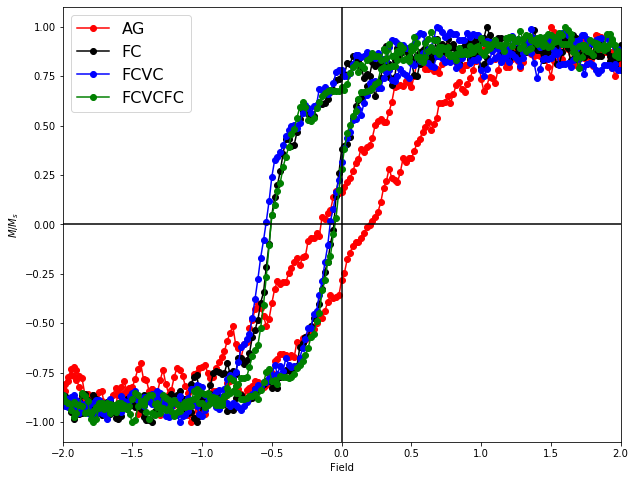

In [31]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
for key, value in data_20180430.items():
#     if key != 'AG':
        
        
#     else:
    m_corrected = normalize(smooth(background_subtract(value['Field'], value['Moment'], hsat=1000), 1))
#     m_corrected = smooth(value['Moment'], 1)
    ax.plot(1e-3*value['Field'], m_corrected, linestyle='-', marker='o', color=colors[key], label=key)
#     ax.plot(1e-3*value['Field'], 1e6*m_corrected, linestyle='-', marker='o', color=colors[key], label=key)
ax.set_xlim(-2, 2)
# ax.set_ylim(-10, 10)
ax.set_ylim(-1.1, 1.1)
ax.axhline(color='k')
ax.axvline(color='k')
ax.legend(prop={'size': 16})
ax.set_xlabel('Field')
ax.set_ylabel('$M/M_s$')
fig.savefig(fname='2018-04-30_AG.svg')

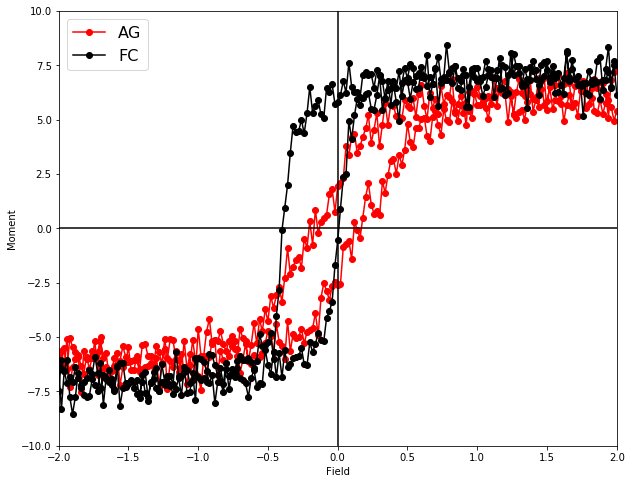

In [8]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
for key, value in data_20180407.items():
    if key in ['AG', 'FC']:
        m_corrected = background_subtract(value['Field'], value['Moment'], hsat=1000)
        ax.plot(1e-3*value['Field'], 1e6*m_corrected, linestyle='-', marker='o', color=colors[key], label=key)
ax.set_xlim(-2, 2)
ax.set_ylim(-10, 10)
ax.axhline(color='k')
ax.axvline(color='k')
ax.legend(prop={'size': 16})
ax.set_xlabel('Field')
ax.set_ylabel('Moment')
fig.savefig(fname='2018-04-07_AG.svg')

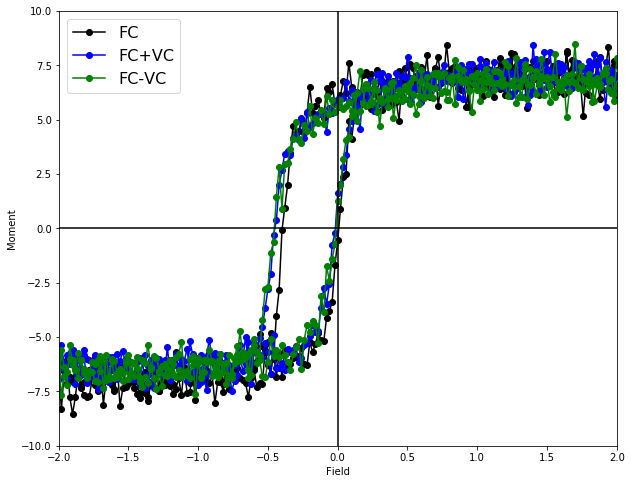

In [9]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
for key, value in data_20180407.items():
    if key in ['FC', 'FC+VC', 'FC-VC']:
        m_corrected = background_subtract(value['Field'], value['Moment'], hsat=1000)
        ax.plot(1e-3*value['Field'], 1e6*m_corrected, linestyle='-', marker='o', color=colors[key], label=key)
ax.set_xlim(-2, 2)
ax.set_ylim(-10, 10)
ax.axhline(color='k')
ax.axvline(color='k')
ax.legend(prop={'size': 16})
ax.set_xlabel('Field')
ax.set_ylabel('Moment')
fig.savefig(fname='2018-04-07_FC-VC.svg')

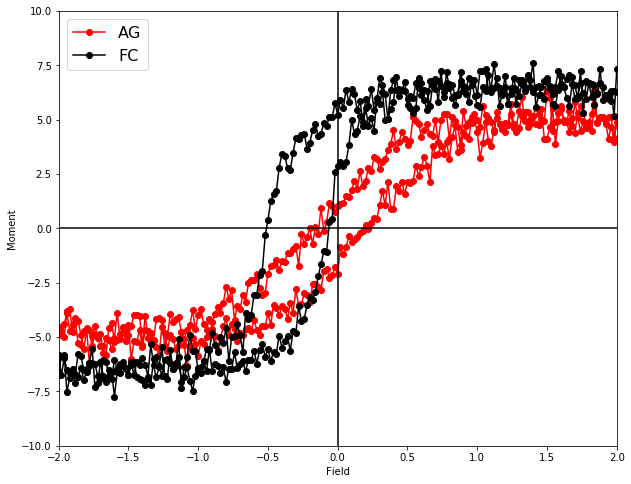

In [10]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
for key, value in data_20180430.items():
    if key in ['AG', 'FC']:
        m_corrected = background_subtract(value['Field'], value['Moment'], hsat=1000)
        ax.plot(1e-3*value['Field'], 1e6*m_corrected, linestyle='-', marker='o', color=colors[key], label=key)
ax.set_xlim(-2, 2)
ax.set_ylim(-10, 10)
ax.axhline(color='k')
ax.axvline(color='k')
ax.legend(prop={'size': 16})
ax.set_xlabel('Field')
ax.set_ylabel('Moment')
fig.savefig(fname='2018-04-30_AG.svg')

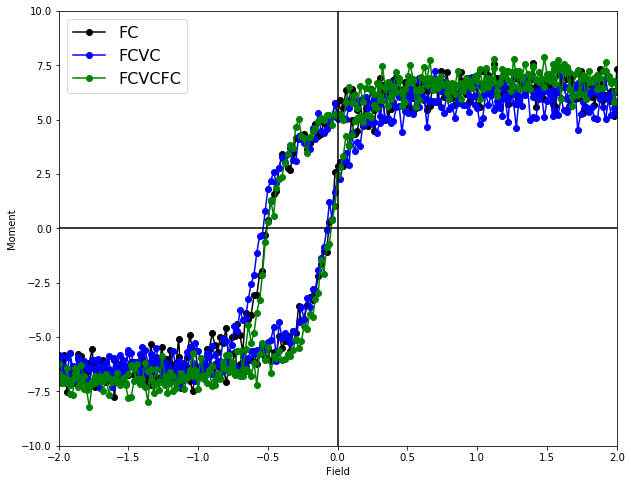

In [11]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
for key, value in data_20180430.items():
    if key in ['FC', 'FCVC', 'FCVCFC']:
        m_corrected = background_subtract(value['Field'], value['Moment'], hsat=1000)
        ax.plot(1e-3*value['Field'], 1e6*m_corrected, linestyle='-', marker='o', color=colors[key], label=key)
ax.set_xlim(-2, 2)
ax.set_ylim(-10, 10)
ax.axhline(color='k')
ax.axvline(color='k')
ax.legend(prop={'size': 16})
ax.set_xlabel('Field')
ax.set_ylabel('Moment')
fig.savefig(fname='2018-04-30_FCVCFC.svg')